In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import sys
import pickle
import copy
import os
import pdb
import numpy as np
import matplotlib.pyplot as plt

def pytorch_to_numpy(x):
  return x.detach().numpy()

if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"

In [39]:
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0]
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=256, shuffle=True,drop_last=True)
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0]
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=256, shuffle=True,drop_last=True)

In [40]:
mnist_trainset_reduced.dataset.train_data.shape

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [41]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)
z_dim = 10
n_epochs = 100

In [42]:
class VAE(torch.nn.Module ):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim,n_rows,n_cols,n_channels):
        super(VAE, self).__init__()

        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_channels = n_channels
        self.n_pixels = (self.n_rows)*(self.n_cols)
        self.z_dim = z_dim

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)


    def encoder(self, x):
        h = F.relu(self.fc1(x.view(-1, self.n_pixels)))
        h = F.relu(self.fc2((h)))
        return F.relu(self.fc31(h)), F.relu(self.fc32(h))

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)).view(-1,n_channels, n_rows,n_cols)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        z_mu, z_log_var = self.encoder(x)
        z = self.sampling(z_mu, z_log_var)
        return self.decoder(z), z_mu, z_log_var

    def loss_function(self,x, y, mu, log_var):
        reconstruction_error = F.binary_cross_entropy(y.view(-1, self.n_pixels), x.view(-1, self.n_pixels), reduction='sum')

        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        return reconstruction_error + KLD

In [43]:
vae_dim_1 = 512
vae_dim_2 = 256
vae_model = VAE(x_dim=n_pixels, h_dim1= vae_dim_1, h_dim2=vae_dim_2, z_dim=z_dim,n_rows=n_rows,n_cols=n_cols,n_channels=n_channels)
vae_optimizer = optim.Adam(vae_model.parameters())

In [44]:
def train_vae(vae_model,data_train_loader,epoch):
  train_loss = 0
  for batch_idx, (data, _) in enumerate(data_train_loader):
    vae_optimizer.zero_grad()
    y, z_mu, z_log_var = vae_model(data)
    loss_vae = vae_model.loss_function(data, y, z_mu, z_log_var)
    loss_vae.backward()
    train_loss += loss_vae.item()
    vae_optimizer.step()

    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(data_train_loader.dataset),
      100. * batch_idx / len(data_train_loader), loss_vae.item() / len(data)))
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_train_loader.dataset)))

In [45]:
n_epochs
for epoch in range(0, n_epochs):
  train_vae(vae_model,mnist_train_loader,epoch)

Train Epoch: 0 [0/1000 (0%)]	Loss: 544.249573
====> Epoch: 0 Average loss: 402.7497
Train Epoch: 1 [0/1000 (0%)]	Loss: 477.297150
====> Epoch: 1 Average loss: 337.9059
Train Epoch: 2 [0/1000 (0%)]	Loss: 354.193115
====> Epoch: 2 Average loss: 246.2511
Train Epoch: 3 [0/1000 (0%)]	Loss: 272.513580
====> Epoch: 3 Average loss: 197.0297
Train Epoch: 4 [0/1000 (0%)]	Loss: 233.982834
====> Epoch: 4 Average loss: 172.7798
Train Epoch: 5 [0/1000 (0%)]	Loss: 216.321899
====> Epoch: 5 Average loss: 169.1867
Train Epoch: 6 [0/1000 (0%)]	Loss: 216.605896
====> Epoch: 6 Average loss: 167.2001
Train Epoch: 7 [0/1000 (0%)]	Loss: 216.891327
====> Epoch: 7 Average loss: 165.0968
Train Epoch: 8 [0/1000 (0%)]	Loss: 214.101837
====> Epoch: 8 Average loss: 164.1245
Train Epoch: 9 [0/1000 (0%)]	Loss: 214.421555
====> Epoch: 9 Average loss: 164.0293
Train Epoch: 10 [0/1000 (0%)]	Loss: 214.319855
====> Epoch: 10 Average loss: 162.7117
Train Epoch: 11 [0/1000 (0%)]	Loss: 208.178421
====> Epoch: 11 Average los

In [46]:
def display_images(imgs):
  r = 1
  c = imgs.shape[0]
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    #black and white images
    axs[j].imshow(pytorch_to_numpy(imgs[j, 0,:,:]), cmap='gray')
    axs[j].axis('off')
  plt.show()

def display_ae_images(ae_model, test_imgs):
  n_images = 5
  idx = np.random.randint(0, test_imgs.shape[0], n_images)
  test_imgs = test_imgs[idx,:,:,:]
  print(test_imgs.shape)
  output_imgs = pytorch_to_numpy(ae_model.forward( test_imgs ))
  print(output_imgs.shape)
  r = 2
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    axs[0,j].imshow(test_imgs[j, 0,:,:], cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(output_imgs[j, 0,:,:], cmap='gray')
    axs[1,j].axis('off')
  plt.show()

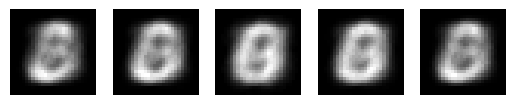

In [47]:
def generate_images_vae(vae_model,n_images = 5):

  epsilon = torch.randn(n_images,1,vae_model.z_dim)
  imgs_generated = vae_model.decoder(epsilon)
  return(imgs_generated)

imgs_generated = generate_images_vae(vae_model,n_images=5)
display_images(imgs_generated)

In [48]:
for epoch in range(0, 1000):
  train_vae(vae_model,mnist_train_loader,epoch)

Train Epoch: 0 [0/1000 (0%)]	Loss: 200.846085
====> Epoch: 0 Average loss: 150.8193
Train Epoch: 1 [0/1000 (0%)]	Loss: 194.568954
====> Epoch: 1 Average loss: 150.6790
Train Epoch: 2 [0/1000 (0%)]	Loss: 192.501175
====> Epoch: 2 Average loss: 148.6723
Train Epoch: 3 [0/1000 (0%)]	Loss: 191.690613
====> Epoch: 3 Average loss: 149.1768
Train Epoch: 4 [0/1000 (0%)]	Loss: 197.201843
====> Epoch: 4 Average loss: 150.1912
Train Epoch: 5 [0/1000 (0%)]	Loss: 194.575317
====> Epoch: 5 Average loss: 150.0460
Train Epoch: 6 [0/1000 (0%)]	Loss: 198.246338
====> Epoch: 6 Average loss: 150.0909
Train Epoch: 7 [0/1000 (0%)]	Loss: 191.657104
====> Epoch: 7 Average loss: 149.7292
Train Epoch: 8 [0/1000 (0%)]	Loss: 194.333893
====> Epoch: 8 Average loss: 150.5292
Train Epoch: 9 [0/1000 (0%)]	Loss: 196.628494
====> Epoch: 9 Average loss: 149.7466
Train Epoch: 10 [0/1000 (0%)]	Loss: 194.836197
====> Epoch: 10 Average loss: 151.0399
Train Epoch: 11 [0/1000 (0%)]	Loss: 195.087524
====> Epoch: 11 Average los

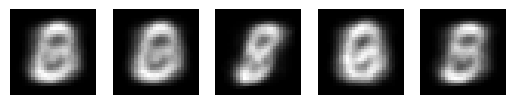

In [73]:
def generate_images_vae(vae_model,n_images = 5):
  epsilon = torch.randn(n_images,1,vae_model.z_dim)
  imgs_generated = vae_model.decoder(epsilon)
  return(imgs_generated)

imgs_generated = generate_images_vae(vae_model,n_images=5)
display_images(imgs_generated)

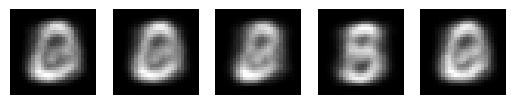

In [50]:
def generate_images_vae(vae_model,n_images = 5):

  epsilon = torch.randn(n_images,1,vae_model.z_dim)
  imgs_generated = vae_model.decoder(epsilon)
  return(imgs_generated)

imgs_generated = generate_images_vae(vae_model,n_images=5)
display_images(imgs_generated)

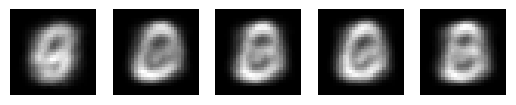

In [51]:
def generate_images_vae(vae_model,n_images = 5):

  epsilon = torch.randn(n_images,1,vae_model.z_dim)
  imgs_generated = vae_model.decoder(epsilon)
  return(imgs_generated)

imgs_generated = generate_images_vae(vae_model,n_images=5)
display_images(imgs_generated)


In [17]:
imgs_generated.shape

torch.Size([5, 1, 28, 28])

In [52]:
from sklearn.metrics import mean_squared_error
from keras.datasets import mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()

mnist_digits = [8,8,8,8,8]
generated_images_np = imgs_generated.detach().numpy().reshape(-1, 784)
mnist_images = x_train[mnist_digits].reshape(-1, 784)
mse = mean_squared_error(mnist_images, generated_images_np)

print(f"The Mean Squared Error between the generated images and the MNIST images is: {mse}")

The Mean Squared Error between the generated images and the MNIST images is: 2949.8916015625


In [53]:
import cv2
mnist_images = mnist_images.astype('float32')
generated_images_np = generated_images_np.astype('float32')

psnr_value = cv2.PSNR(mnist_images, generated_images_np)

print(f"The Peak Signal-to-Noise Ratio between the generated images and the MNIST images is: {psnr_value}")


The Peak Signal-to-Noise Ratio between the generated images and the MNIST images is: 13.432742915196494


In [20]:
generated_images_np.shape

(5, 784)

In [21]:
from sklearn.decomposition import PCA
def plot_latent_space(vae_model, data_loader):
    vae_model.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(data_loader):
            z_mu, z_log_var = vae_model.encoder(data)
            z = vae_model.sampling(z_mu, z_log_var)
        z = z.detach().numpy()
        pca = PCA(n_components=2)
        latent = pca.fit_transform(z)
        plt.scatter(latent[:, 0], latent[:, 1], c=labels, cmap='tab10')
        plt.colorbar()
        plt.show()
        print(latent.shape)

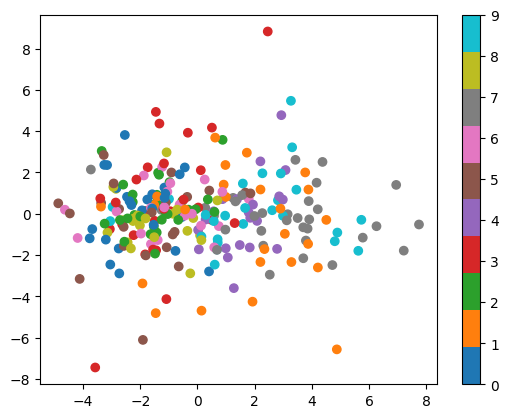

(256, 2)


In [54]:
plot_latent_space(vae_model, mnist_train_loader)

In [55]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0]
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0]
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)

In [56]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [57]:
z_dim = 10
batch_size = 64
n_epochs = 400
n_iters_inner=1
sample_interval=100
lr = 0.0002
beta_1 = 0.5
h_dim_1 = 256
h_dim_2 = 512

In [58]:

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim
    self.fc1 = nn.Linear(self.z_dim, self.h_dim_1)
    self.fc2 = nn.Linear(self.h_dim_1, self.h_dim_2)
    self.fc3 = nn.Linear(self.h_dim_2, self.n_pixels * self.n_channels)

  def forward(self, z):
    y = self.fc1(z)
    y = nn.LeakyReLU(0.2)(y)
    y = self.fc2(y)
    y = nn.LeakyReLU(0.2)(y)
    y = self.fc3(y)
    y = torch.tanh(y)
    y = y.view(-1, self.n_channels, self.n_rows, self.n_cols)
    return(y)

In [59]:
class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim
    self.fc1 = nn.Linear(self.n_pixels * self.n_channels, self.h_dim_2)
    self.fc2 = nn.Linear(self.h_dim_2, self.h_dim_1)
    self.fc3 = nn.Linear(self.h_dim_1, 1)

  def forward(self, x):
    y = x.view(-1, self.n_pixels * self.n_channels)
    y = self.fc1(y)
    y = nn.LeakyReLU(0.2)(y)
    y = self.fc2(y)
    y = nn.LeakyReLU(0.2)(y)
    y = self.fc3(y)
    y = torch.sigmoid(y)
    return y

In [60]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows, n_cols, n_channels).to(device)
print(gen_model)

disc_model = Discriminator(h_dim_1, h_dim_2, z_dim, n_rows, n_cols, n_channels).to(device) # FILL IN HERE, CAREFUL OF ORDER OF PARAMETERS
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
)


In [61]:
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))
bce_criterion = nn.BCELoss()
def loss_fn_gen(d_gen_data):
  loss_gen = -torch.mean(torch.log(d_gen_data))
  return loss_gen

In [80]:
def sample_images(generator, z_dim, rand_seed=30):
  r, c = 1, 5  # Change this to generate 5 images
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device=device)
  gen_imgs = np.transpose(generator(z_random).cpu().detach().numpy(), (0,2,3,1))
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      if(gen_imgs.shape[3] == 1):
        axs[j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')  # Change this
      elif(gen_imgs.shape[3] == 3):
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0)
        axs[j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))  # Change this
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[j].axis('off')  # Change this
      cnt += 1
  plt.show()
  return gen_imgs


Starting Training
[0/400][0/16] 	Loss_D: 1.3929	Loss_G: 0.6867	D(x): 0.5008	D(G(z)): 0.5039


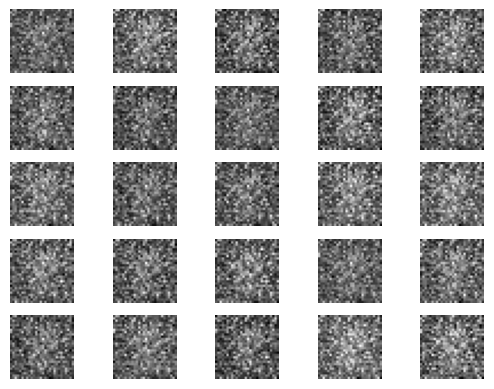

[1/400][0/16] 	Loss_D: 0.9675	Loss_G: 0.6206	D(x): 0.8945	D(G(z)): 0.5747
[2/400][0/16] 	Loss_D: 1.1766	Loss_G: 0.6096	D(x): 0.7822	D(G(z)): 0.6047
[3/400][0/16] 	Loss_D: 1.1933	Loss_G: 0.7026	D(x): 0.7054	D(G(z)): 0.5694
[4/400][0/16] 	Loss_D: 1.2771	Loss_G: 0.7764	D(x): 0.6590	D(G(z)): 0.5757
[5/400][0/16] 	Loss_D: 1.1378	Loss_G: 0.9710	D(x): 0.6966	D(G(z)): 0.5384
[6/400][0/16] 	Loss_D: 1.0717	Loss_G: 1.1191	D(x): 0.7202	D(G(z)): 0.5211
[7/400][0/16] 	Loss_D: 1.1422	Loss_G: 1.1789	D(x): 0.7530	D(G(z)): 0.5692
[8/400][0/16] 	Loss_D: 0.9190	Loss_G: 1.5319	D(x): 0.7577	D(G(z)): 0.4674
[9/400][0/16] 	Loss_D: 0.9488	Loss_G: 1.2176	D(x): 0.7468	D(G(z)): 0.4784
[10/400][0/16] 	Loss_D: 1.1478	Loss_G: 0.9466	D(x): 0.6169	D(G(z)): 0.4808
[11/400][0/16] 	Loss_D: 1.3188	Loss_G: 0.8348	D(x): 0.6350	D(G(z)): 0.5738
[12/400][0/16] 	Loss_D: 1.3921	Loss_G: 0.7819	D(x): 0.5830	D(G(z)): 0.5684
[13/400][0/16] 	Loss_D: 1.3067	Loss_G: 0.9372	D(x): 0.6469	D(G(z)): 0.5775
[14/400][0/16] 	Loss_D: 1.3043	Los

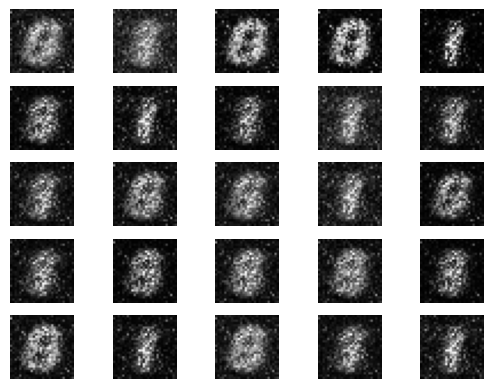

[26/400][0/16] 	Loss_D: 1.3026	Loss_G: 0.8498	D(x): 0.5414	D(G(z)): 0.4817
[27/400][0/16] 	Loss_D: 1.1278	Loss_G: 0.7770	D(x): 0.5334	D(G(z)): 0.3797
[28/400][0/16] 	Loss_D: 1.2136	Loss_G: 1.2230	D(x): 0.6617	D(G(z)): 0.5419
[29/400][0/16] 	Loss_D: 1.0537	Loss_G: 1.0805	D(x): 0.6120	D(G(z)): 0.4165
[30/400][0/16] 	Loss_D: 0.9357	Loss_G: 1.6963	D(x): 0.7450	D(G(z)): 0.4632
[31/400][0/16] 	Loss_D: 1.0136	Loss_G: 1.3169	D(x): 0.6771	D(G(z)): 0.4449
[32/400][0/16] 	Loss_D: 0.9571	Loss_G: 1.7541	D(x): 0.7771	D(G(z)): 0.4769
[33/400][0/16] 	Loss_D: 1.1588	Loss_G: 1.7662	D(x): 0.7256	D(G(z)): 0.5410
[34/400][0/16] 	Loss_D: 1.0168	Loss_G: 1.0346	D(x): 0.4936	D(G(z)): 0.2078
[35/400][0/16] 	Loss_D: 1.1955	Loss_G: 1.5351	D(x): 0.7637	D(G(z)): 0.5829
[36/400][0/16] 	Loss_D: 0.9586	Loss_G: 1.6028	D(x): 0.7330	D(G(z)): 0.4620
[37/400][0/16] 	Loss_D: 1.0306	Loss_G: 1.2403	D(x): 0.6424	D(G(z)): 0.4144
[38/400][0/16] 	Loss_D: 0.9064	Loss_G: 0.9605	D(x): 0.5964	D(G(z)): 0.2773
[39/400][0/16] 	Loss_D: 1

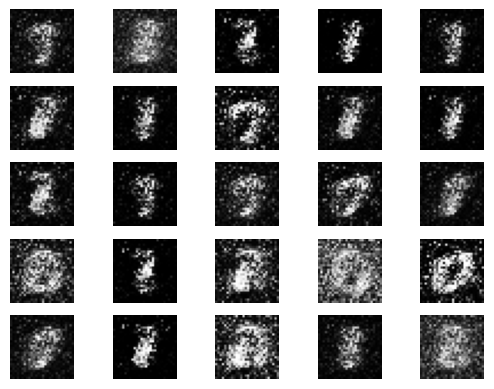

[51/400][0/16] 	Loss_D: 0.9803	Loss_G: 1.2563	D(x): 0.5325	D(G(z)): 0.2183
[52/400][0/16] 	Loss_D: 0.6823	Loss_G: 1.4242	D(x): 0.7098	D(G(z)): 0.2651
[53/400][0/16] 	Loss_D: 0.8263	Loss_G: 1.5271	D(x): 0.7091	D(G(z)): 0.3509
[54/400][0/16] 	Loss_D: 0.8859	Loss_G: 1.2224	D(x): 0.6646	D(G(z)): 0.3305
[55/400][0/16] 	Loss_D: 0.8480	Loss_G: 1.6870	D(x): 0.7096	D(G(z)): 0.3697
[56/400][0/16] 	Loss_D: 0.8140	Loss_G: 1.4831	D(x): 0.6524	D(G(z)): 0.2731
[57/400][0/16] 	Loss_D: 0.8688	Loss_G: 1.9215	D(x): 0.8033	D(G(z)): 0.4532
[58/400][0/16] 	Loss_D: 1.2202	Loss_G: 2.6609	D(x): 0.8990	D(G(z)): 0.6499
[59/400][0/16] 	Loss_D: 1.0149	Loss_G: 2.4082	D(x): 0.8615	D(G(z)): 0.5612
[60/400][0/16] 	Loss_D: 0.9580	Loss_G: 1.2280	D(x): 0.6278	D(G(z)): 0.3346
[61/400][0/16] 	Loss_D: 0.9044	Loss_G: 1.5348	D(x): 0.7042	D(G(z)): 0.3911
[62/400][0/16] 	Loss_D: 0.8382	Loss_G: 1.2917	D(x): 0.6399	D(G(z)): 0.2748
[63/400][0/16] 	Loss_D: 0.9390	Loss_G: 1.7346	D(x): 0.7900	D(G(z)): 0.4815
[64/400][0/16] 	Loss_D: 0

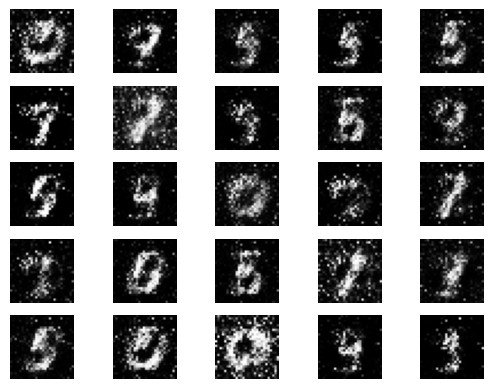

[76/400][0/16] 	Loss_D: 0.8008	Loss_G: 1.3538	D(x): 0.7450	D(G(z)): 0.3542
[77/400][0/16] 	Loss_D: 0.8778	Loss_G: 1.3834	D(x): 0.6804	D(G(z)): 0.3321
[78/400][0/16] 	Loss_D: 0.9358	Loss_G: 1.7147	D(x): 0.7271	D(G(z)): 0.4133
[79/400][0/16] 	Loss_D: 1.0599	Loss_G: 2.0160	D(x): 0.8145	D(G(z)): 0.5519
[80/400][0/16] 	Loss_D: 0.9280	Loss_G: 1.6264	D(x): 0.7499	D(G(z)): 0.4401
[81/400][0/16] 	Loss_D: 0.8535	Loss_G: 1.6671	D(x): 0.7192	D(G(z)): 0.3757
[82/400][0/16] 	Loss_D: 0.7454	Loss_G: 1.8570	D(x): 0.7848	D(G(z)): 0.3660
[83/400][0/16] 	Loss_D: 0.9335	Loss_G: 0.7708	D(x): 0.5332	D(G(z)): 0.1763
[84/400][0/16] 	Loss_D: 1.1515	Loss_G: 3.0962	D(x): 0.9044	D(G(z)): 0.6295
[85/400][0/16] 	Loss_D: 0.8816	Loss_G: 1.2588	D(x): 0.5334	D(G(z)): 0.1356
[86/400][0/16] 	Loss_D: 1.0205	Loss_G: 2.2322	D(x): 0.8915	D(G(z)): 0.5693
[87/400][0/16] 	Loss_D: 0.8737	Loss_G: 1.1977	D(x): 0.6223	D(G(z)): 0.2872
[88/400][0/16] 	Loss_D: 1.3691	Loss_G: 0.8890	D(x): 0.3518	D(G(z)): 0.0666
[89/400][0/16] 	Loss_D: 0

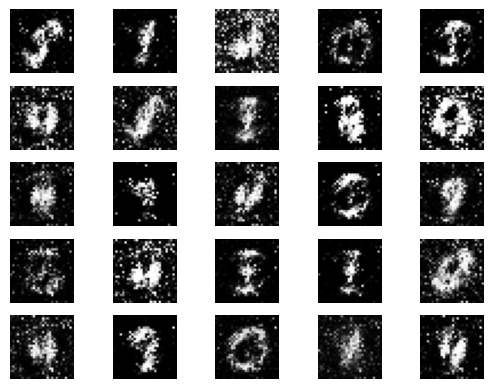

[101/400][0/16] 	Loss_D: 0.8031	Loss_G: 1.2953	D(x): 0.5979	D(G(z)): 0.1897
[102/400][0/16] 	Loss_D: 0.8019	Loss_G: 1.1156	D(x): 0.6371	D(G(z)): 0.2324
[103/400][0/16] 	Loss_D: 1.1284	Loss_G: 2.8603	D(x): 0.8356	D(G(z)): 0.5787
[104/400][0/16] 	Loss_D: 0.8620	Loss_G: 1.6280	D(x): 0.7305	D(G(z)): 0.3649
[105/400][0/16] 	Loss_D: 0.8531	Loss_G: 1.2155	D(x): 0.6143	D(G(z)): 0.2337
[106/400][0/16] 	Loss_D: 0.8101	Loss_G: 1.3827	D(x): 0.6676	D(G(z)): 0.2718
[107/400][0/16] 	Loss_D: 0.8702	Loss_G: 1.5107	D(x): 0.6882	D(G(z)): 0.3359
[108/400][0/16] 	Loss_D: 0.9507	Loss_G: 2.5824	D(x): 0.8519	D(G(z)): 0.5242
[109/400][0/16] 	Loss_D: 0.9129	Loss_G: 1.0634	D(x): 0.5702	D(G(z)): 0.2120
[110/400][0/16] 	Loss_D: 0.8707	Loss_G: 1.8411	D(x): 0.7195	D(G(z)): 0.3804
[111/400][0/16] 	Loss_D: 1.2097	Loss_G: 0.6054	D(x): 0.4097	D(G(z)): 0.0823
[112/400][0/16] 	Loss_D: 0.9614	Loss_G: 1.8057	D(x): 0.7943	D(G(z)): 0.4816
[113/400][0/16] 	Loss_D: 1.0827	Loss_G: 2.4669	D(x): 0.9191	D(G(z)): 0.5985
[114/400][0/

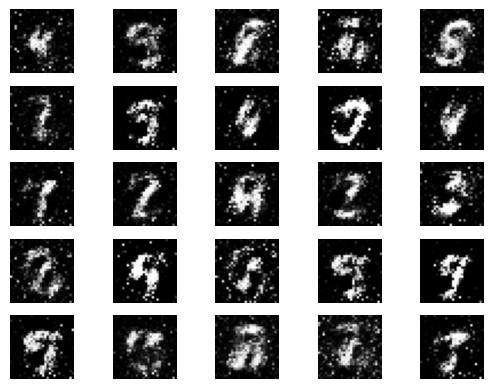

[126/400][0/16] 	Loss_D: 0.8645	Loss_G: 1.3051	D(x): 0.6050	D(G(z)): 0.1833
[127/400][0/16] 	Loss_D: 0.7775	Loss_G: 1.2146	D(x): 0.6092	D(G(z)): 0.1641
[128/400][0/16] 	Loss_D: 0.7329	Loss_G: 1.6566	D(x): 0.6460	D(G(z)): 0.1855
[129/400][0/16] 	Loss_D: 0.7560	Loss_G: 1.7235	D(x): 0.7338	D(G(z)): 0.3189
[130/400][0/16] 	Loss_D: 0.8070	Loss_G: 2.3028	D(x): 0.8241	D(G(z)): 0.4242
[131/400][0/16] 	Loss_D: 0.6482	Loss_G: 1.6337	D(x): 0.7229	D(G(z)): 0.2420
[132/400][0/16] 	Loss_D: 0.8595	Loss_G: 1.1882	D(x): 0.6305	D(G(z)): 0.2344
[133/400][0/16] 	Loss_D: 0.8241	Loss_G: 1.0123	D(x): 0.6375	D(G(z)): 0.2287
[134/400][0/16] 	Loss_D: 1.2152	Loss_G: 3.5924	D(x): 0.9343	D(G(z)): 0.6634
[135/400][0/16] 	Loss_D: 0.9624	Loss_G: 0.7502	D(x): 0.5238	D(G(z)): 0.1310
[136/400][0/16] 	Loss_D: 0.8159	Loss_G: 1.9489	D(x): 0.8023	D(G(z)): 0.4135
[137/400][0/16] 	Loss_D: 0.8179	Loss_G: 1.7052	D(x): 0.7427	D(G(z)): 0.3477
[138/400][0/16] 	Loss_D: 0.8772	Loss_G: 1.1763	D(x): 0.6096	D(G(z)): 0.2302
[139/400][0/

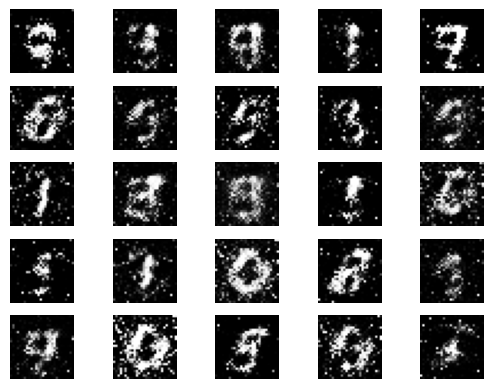

[151/400][0/16] 	Loss_D: 0.8988	Loss_G: 3.4499	D(x): 0.8738	D(G(z)): 0.5085
[152/400][0/16] 	Loss_D: 1.1958	Loss_G: 0.5209	D(x): 0.4285	D(G(z)): 0.0901
[153/400][0/16] 	Loss_D: 0.9887	Loss_G: 3.1121	D(x): 0.8668	D(G(z)): 0.5413
[154/400][0/16] 	Loss_D: 0.8510	Loss_G: 2.6716	D(x): 0.8732	D(G(z)): 0.4882
[155/400][0/16] 	Loss_D: 0.6051	Loss_G: 1.8776	D(x): 0.8401	D(G(z)): 0.3191
[156/400][0/16] 	Loss_D: 1.1610	Loss_G: 0.5503	D(x): 0.4392	D(G(z)): 0.0837
[157/400][0/16] 	Loss_D: 0.7114	Loss_G: 2.0837	D(x): 0.8392	D(G(z)): 0.3678
[158/400][0/16] 	Loss_D: 0.8704	Loss_G: 2.4162	D(x): 0.7979	D(G(z)): 0.4100
[159/400][0/16] 	Loss_D: 0.7889	Loss_G: 1.4581	D(x): 0.6062	D(G(z)): 0.1530
[160/400][0/16] 	Loss_D: 0.6570	Loss_G: 1.5041	D(x): 0.6964	D(G(z)): 0.1883
[161/400][0/16] 	Loss_D: 1.0480	Loss_G: 3.3276	D(x): 0.9235	D(G(z)): 0.5856
[162/400][0/16] 	Loss_D: 0.8009	Loss_G: 1.7447	D(x): 0.7270	D(G(z)): 0.2970
[163/400][0/16] 	Loss_D: 0.8845	Loss_G: 0.8618	D(x): 0.5741	D(G(z)): 0.1387
[164/400][0/

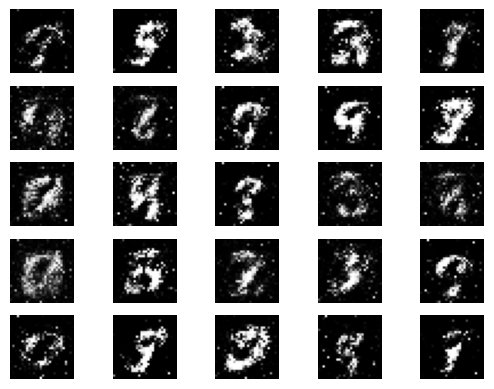

[176/400][0/16] 	Loss_D: 0.9134	Loss_G: 2.7362	D(x): 0.8308	D(G(z)): 0.4627
[177/400][0/16] 	Loss_D: 0.5433	Loss_G: 2.2884	D(x): 0.7258	D(G(z)): 0.1330
[178/400][0/16] 	Loss_D: 0.9702	Loss_G: 1.0527	D(x): 0.5225	D(G(z)): 0.1079
[179/400][0/16] 	Loss_D: 0.8495	Loss_G: 1.5510	D(x): 0.5677	D(G(z)): 0.0909
[180/400][0/16] 	Loss_D: 0.8321	Loss_G: 2.9007	D(x): 0.8305	D(G(z)): 0.4326
[181/400][0/16] 	Loss_D: 0.8231	Loss_G: 2.6973	D(x): 0.8464	D(G(z)): 0.4210
[182/400][0/16] 	Loss_D: 0.9043	Loss_G: 2.6346	D(x): 0.8582	D(G(z)): 0.4637
[183/400][0/16] 	Loss_D: 0.8142	Loss_G: 2.0716	D(x): 0.7974	D(G(z)): 0.3878
[184/400][0/16] 	Loss_D: 0.7190	Loss_G: 2.2248	D(x): 0.7786	D(G(z)): 0.3324
[185/400][0/16] 	Loss_D: 0.7690	Loss_G: 2.4735	D(x): 0.8187	D(G(z)): 0.3875
[186/400][0/16] 	Loss_D: 1.0089	Loss_G: 1.0189	D(x): 0.4824	D(G(z)): 0.0872
[187/400][0/16] 	Loss_D: 0.8578	Loss_G: 1.1917	D(x): 0.6278	D(G(z)): 0.1991
[188/400][0/16] 	Loss_D: 0.6914	Loss_G: 2.5183	D(x): 0.8790	D(G(z)): 0.4044
[189/400][0/

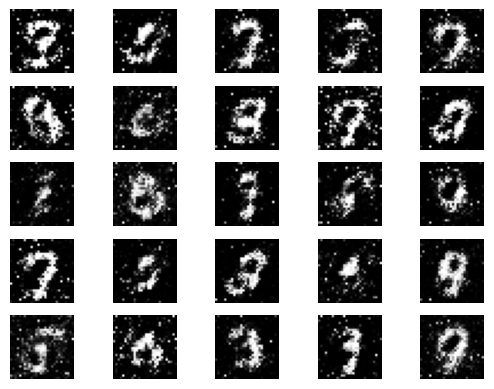

[201/400][0/16] 	Loss_D: 0.6032	Loss_G: 1.8222	D(x): 0.7890	D(G(z)): 0.2574
[202/400][0/16] 	Loss_D: 0.9980	Loss_G: 3.4040	D(x): 0.8964	D(G(z)): 0.5516
[203/400][0/16] 	Loss_D: 0.8265	Loss_G: 2.3236	D(x): 0.7777	D(G(z)): 0.3503
[204/400][0/16] 	Loss_D: 0.8027	Loss_G: 2.6727	D(x): 0.8629	D(G(z)): 0.4214
[205/400][0/16] 	Loss_D: 0.7164	Loss_G: 1.6671	D(x): 0.6763	D(G(z)): 0.1719
[206/400][0/16] 	Loss_D: 0.8594	Loss_G: 2.6185	D(x): 0.8666	D(G(z)): 0.4422
[207/400][0/16] 	Loss_D: 1.1303	Loss_G: 3.4801	D(x): 0.9260	D(G(z)): 0.6103
[208/400][0/16] 	Loss_D: 0.6215	Loss_G: 2.0268	D(x): 0.7633	D(G(z)): 0.2454
[209/400][0/16] 	Loss_D: 0.8147	Loss_G: 0.8345	D(x): 0.5858	D(G(z)): 0.1097
[210/400][0/16] 	Loss_D: 0.9633	Loss_G: 2.5051	D(x): 0.8121	D(G(z)): 0.4692
[211/400][0/16] 	Loss_D: 0.8033	Loss_G: 2.8226	D(x): 0.9000	D(G(z)): 0.4666
[212/400][0/16] 	Loss_D: 0.9098	Loss_G: 3.2343	D(x): 0.8865	D(G(z)): 0.4984
[213/400][0/16] 	Loss_D: 0.6307	Loss_G: 1.9807	D(x): 0.7909	D(G(z)): 0.2899
[214/400][0/

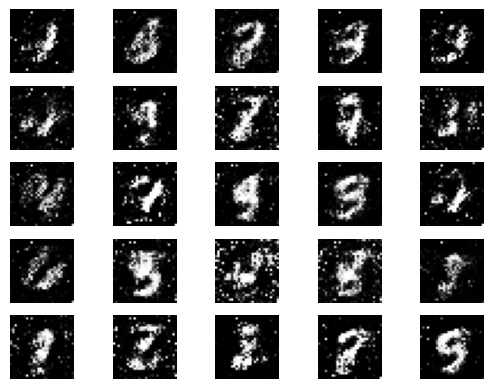

[226/400][0/16] 	Loss_D: 0.8582	Loss_G: 2.5190	D(x): 0.8949	D(G(z)): 0.4650
[227/400][0/16] 	Loss_D: 0.8803	Loss_G: 2.8468	D(x): 0.8604	D(G(z)): 0.4715
[228/400][0/16] 	Loss_D: 0.8043	Loss_G: 2.4246	D(x): 0.8044	D(G(z)): 0.3857
[229/400][0/16] 	Loss_D: 0.8954	Loss_G: 2.7392	D(x): 0.9008	D(G(z)): 0.4921
[230/400][0/16] 	Loss_D: 0.6488	Loss_G: 2.1638	D(x): 0.7958	D(G(z)): 0.2894
[231/400][0/16] 	Loss_D: 1.2353	Loss_G: 3.5237	D(x): 0.9672	D(G(z)): 0.6427
[232/400][0/16] 	Loss_D: 0.6506	Loss_G: 1.5470	D(x): 0.6657	D(G(z)): 0.1181
[233/400][0/16] 	Loss_D: 0.6309	Loss_G: 2.1369	D(x): 0.8305	D(G(z)): 0.2994
[234/400][0/16] 	Loss_D: 0.7861	Loss_G: 2.5011	D(x): 0.8207	D(G(z)): 0.3767
[235/400][0/16] 	Loss_D: 0.7539	Loss_G: 1.7364	D(x): 0.6518	D(G(z)): 0.1313
[236/400][0/16] 	Loss_D: 1.0974	Loss_G: 1.3125	D(x): 0.4881	D(G(z)): 0.0408
[237/400][0/16] 	Loss_D: 0.9511	Loss_G: 1.0675	D(x): 0.5096	D(G(z)): 0.0659
[238/400][0/16] 	Loss_D: 1.0464	Loss_G: 3.0605	D(x): 0.9092	D(G(z)): 0.5513
[239/400][0/

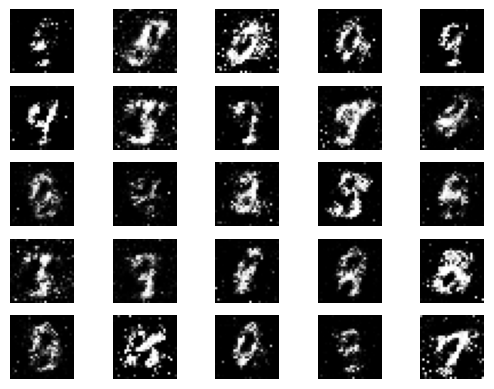

[251/400][0/16] 	Loss_D: 0.7025	Loss_G: 1.4920	D(x): 0.7096	D(G(z)): 0.1968
[252/400][0/16] 	Loss_D: 0.7128	Loss_G: 2.7257	D(x): 0.8093	D(G(z)): 0.3206
[253/400][0/16] 	Loss_D: 1.6653	Loss_G: 0.7286	D(x): 0.3502	D(G(z)): 0.0279
[254/400][0/16] 	Loss_D: 0.6809	Loss_G: 1.6041	D(x): 0.7177	D(G(z)): 0.2133
[255/400][0/16] 	Loss_D: 0.7105	Loss_G: 1.0152	D(x): 0.6191	D(G(z)): 0.1028
[256/400][0/16] 	Loss_D: 0.9895	Loss_G: 3.3278	D(x): 0.9225	D(G(z)): 0.5113
[257/400][0/16] 	Loss_D: 0.7144	Loss_G: 1.5434	D(x): 0.6167	D(G(z)): 0.0666
[258/400][0/16] 	Loss_D: 0.7011	Loss_G: 1.5421	D(x): 0.7174	D(G(z)): 0.2186
[259/400][0/16] 	Loss_D: 0.6891	Loss_G: 2.7360	D(x): 0.8830	D(G(z)): 0.3865
[260/400][0/16] 	Loss_D: 0.5432	Loss_G: 1.7278	D(x): 0.7273	D(G(z)): 0.1250
[261/400][0/16] 	Loss_D: 0.7779	Loss_G: 1.4506	D(x): 0.5999	D(G(z)): 0.0729
[262/400][0/16] 	Loss_D: 0.6550	Loss_G: 2.0463	D(x): 0.7552	D(G(z)): 0.2256
[263/400][0/16] 	Loss_D: 0.8913	Loss_G: 1.2626	D(x): 0.5379	D(G(z)): 0.0586
[264/400][0/

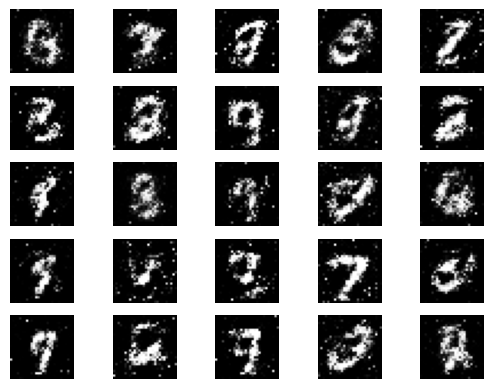

[276/400][0/16] 	Loss_D: 0.6580	Loss_G: 2.3693	D(x): 0.8128	D(G(z)): 0.2996
[277/400][0/16] 	Loss_D: 0.6715	Loss_G: 1.6063	D(x): 0.7696	D(G(z)): 0.2484
[278/400][0/16] 	Loss_D: 0.6857	Loss_G: 2.3680	D(x): 0.8688	D(G(z)): 0.3644
[279/400][0/16] 	Loss_D: 0.7302	Loss_G: 3.2931	D(x): 0.9053	D(G(z)): 0.4059
[280/400][0/16] 	Loss_D: 0.8553	Loss_G: 2.8779	D(x): 0.9003	D(G(z)): 0.4790
[281/400][0/16] 	Loss_D: 0.6913	Loss_G: 1.9343	D(x): 0.7554	D(G(z)): 0.2666
[282/400][0/16] 	Loss_D: 0.9850	Loss_G: 3.5916	D(x): 0.9243	D(G(z)): 0.5503
[283/400][0/16] 	Loss_D: 0.5765	Loss_G: 1.8709	D(x): 0.7698	D(G(z)): 0.1862
[284/400][0/16] 	Loss_D: 0.5024	Loss_G: 1.9163	D(x): 0.8137	D(G(z)): 0.2155
[285/400][0/16] 	Loss_D: 0.9681	Loss_G: 1.2820	D(x): 0.5381	D(G(z)): 0.0574
[286/400][0/16] 	Loss_D: 0.7213	Loss_G: 1.1278	D(x): 0.6388	D(G(z)): 0.1114
[287/400][0/16] 	Loss_D: 0.7074	Loss_G: 2.9512	D(x): 0.8911	D(G(z)): 0.4056
[288/400][0/16] 	Loss_D: 0.8391	Loss_G: 3.2288	D(x): 0.8776	D(G(z)): 0.4362
[289/400][0/

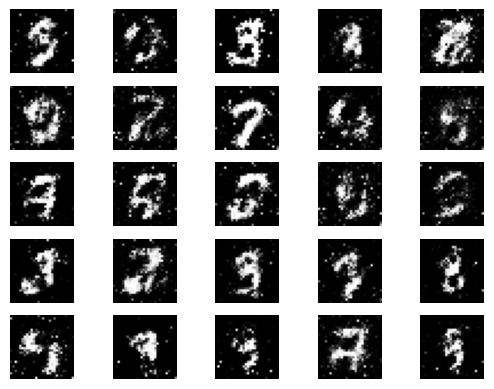

[301/400][0/16] 	Loss_D: 0.5922	Loss_G: 1.3606	D(x): 0.8067	D(G(z)): 0.2553
[302/400][0/16] 	Loss_D: 0.6312	Loss_G: 1.0211	D(x): 0.6911	D(G(z)): 0.1128
[303/400][0/16] 	Loss_D: 0.6545	Loss_G: 1.2739	D(x): 0.6867	D(G(z)): 0.1221
[304/400][0/16] 	Loss_D: 0.6183	Loss_G: 2.3607	D(x): 0.8298	D(G(z)): 0.2949
[305/400][0/16] 	Loss_D: 0.6040	Loss_G: 2.9106	D(x): 0.8575	D(G(z)): 0.3071
[306/400][0/16] 	Loss_D: 0.8713	Loss_G: 3.4315	D(x): 0.8704	D(G(z)): 0.4583
[307/400][0/16] 	Loss_D: 0.8681	Loss_G: 1.0685	D(x): 0.5727	D(G(z)): 0.0738
[308/400][0/16] 	Loss_D: 0.9493	Loss_G: 3.7014	D(x): 0.9204	D(G(z)): 0.5297
[309/400][0/16] 	Loss_D: 0.6271	Loss_G: 1.7771	D(x): 0.8040	D(G(z)): 0.2722
[310/400][0/16] 	Loss_D: 0.7808	Loss_G: 1.7879	D(x): 0.5946	D(G(z)): 0.0607
[311/400][0/16] 	Loss_D: 0.6362	Loss_G: 2.7136	D(x): 0.8837	D(G(z)): 0.3533
[312/400][0/16] 	Loss_D: 0.5327	Loss_G: 1.7254	D(x): 0.7651	D(G(z)): 0.1578
[313/400][0/16] 	Loss_D: 0.6715	Loss_G: 1.6150	D(x): 0.7183	D(G(z)): 0.1887
[314/400][0/

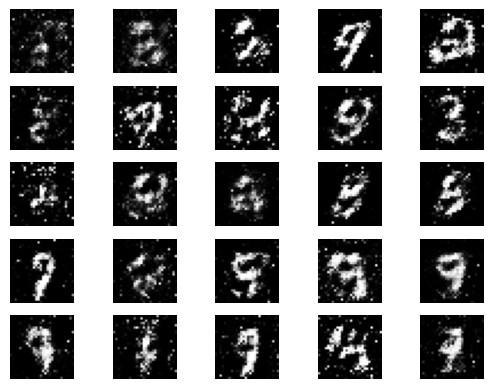

[326/400][0/16] 	Loss_D: 0.8764	Loss_G: 1.1281	D(x): 0.6045	D(G(z)): 0.0667
[327/400][0/16] 	Loss_D: 0.6508	Loss_G: 2.2163	D(x): 0.8297	D(G(z)): 0.2854
[328/400][0/16] 	Loss_D: 0.7999	Loss_G: 2.9862	D(x): 0.8727	D(G(z)): 0.4209
[329/400][0/16] 	Loss_D: 0.5814	Loss_G: 2.7403	D(x): 0.8732	D(G(z)): 0.3169
[330/400][0/16] 	Loss_D: 0.5787	Loss_G: 1.6195	D(x): 0.7302	D(G(z)): 0.1650
[331/400][0/16] 	Loss_D: 0.6476	Loss_G: 2.2297	D(x): 0.8101	D(G(z)): 0.3041
[332/400][0/16] 	Loss_D: 0.7283	Loss_G: 2.7953	D(x): 0.9177	D(G(z)): 0.3908
[333/400][0/16] 	Loss_D: 0.7973	Loss_G: 1.1446	D(x): 0.6259	D(G(z)): 0.1027
[334/400][0/16] 	Loss_D: 0.6874	Loss_G: 1.9047	D(x): 0.7756	D(G(z)): 0.2756
[335/400][0/16] 	Loss_D: 0.7963	Loss_G: 1.2778	D(x): 0.5992	D(G(z)): 0.0854
[336/400][0/16] 	Loss_D: 0.7962	Loss_G: 2.6787	D(x): 0.8646	D(G(z)): 0.4212
[337/400][0/16] 	Loss_D: 0.7210	Loss_G: 1.2339	D(x): 0.6203	D(G(z)): 0.0901
[338/400][0/16] 	Loss_D: 1.0498	Loss_G: 3.2536	D(x): 0.8790	D(G(z)): 0.5296
[339/400][0/

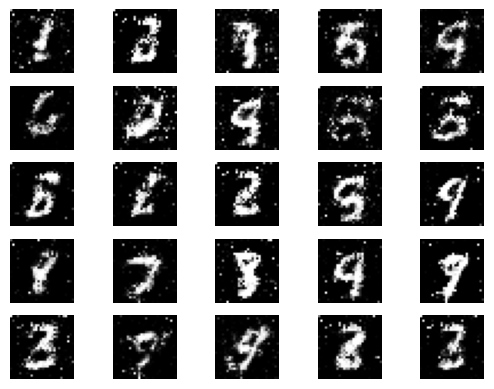

[351/400][0/16] 	Loss_D: 0.9279	Loss_G: 2.6713	D(x): 0.9201	D(G(z)): 0.5068
[352/400][0/16] 	Loss_D: 0.8526	Loss_G: 3.3406	D(x): 0.8959	D(G(z)): 0.4814
[353/400][0/16] 	Loss_D: 1.0736	Loss_G: 3.3713	D(x): 0.9244	D(G(z)): 0.5529
[354/400][0/16] 	Loss_D: 0.7373	Loss_G: 1.0991	D(x): 0.6407	D(G(z)): 0.1487
[355/400][0/16] 	Loss_D: 1.1441	Loss_G: 3.2189	D(x): 0.9290	D(G(z)): 0.5880
[356/400][0/16] 	Loss_D: 0.8110	Loss_G: 1.0744	D(x): 0.5627	D(G(z)): 0.0744
[357/400][0/16] 	Loss_D: 0.6972	Loss_G: 2.7801	D(x): 0.8381	D(G(z)): 0.3446
[358/400][0/16] 	Loss_D: 0.5699	Loss_G: 1.8005	D(x): 0.7412	D(G(z)): 0.1712
[359/400][0/16] 	Loss_D: 0.7920	Loss_G: 1.0181	D(x): 0.6062	D(G(z)): 0.1322
[360/400][0/16] 	Loss_D: 0.8854	Loss_G: 1.7429	D(x): 0.5962	D(G(z)): 0.1296
[361/400][0/16] 	Loss_D: 0.6680	Loss_G: 2.1518	D(x): 0.7304	D(G(z)): 0.2028
[362/400][0/16] 	Loss_D: 0.7006	Loss_G: 1.6532	D(x): 0.7037	D(G(z)): 0.2081
[363/400][0/16] 	Loss_D: 0.9066	Loss_G: 2.2023	D(x): 0.8111	D(G(z)): 0.3906
[364/400][0/

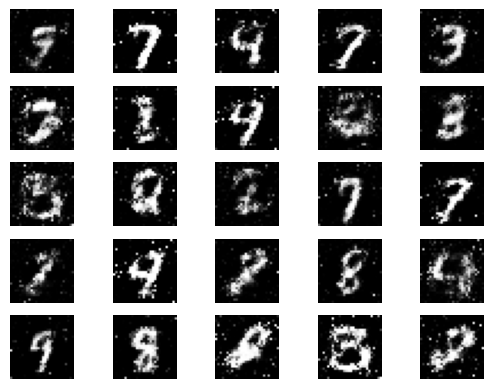

[376/400][0/16] 	Loss_D: 0.5670	Loss_G: 2.0555	D(x): 0.8272	D(G(z)): 0.2829
[377/400][0/16] 	Loss_D: 1.0684	Loss_G: 0.6437	D(x): 0.4659	D(G(z)): 0.0617
[378/400][0/16] 	Loss_D: 0.7296	Loss_G: 1.7429	D(x): 0.6910	D(G(z)): 0.1937
[379/400][0/16] 	Loss_D: 0.7352	Loss_G: 1.4873	D(x): 0.7076	D(G(z)): 0.2348
[380/400][0/16] 	Loss_D: 0.7965	Loss_G: 2.2186	D(x): 0.8122	D(G(z)): 0.3537
[381/400][0/16] 	Loss_D: 0.7543	Loss_G: 2.8802	D(x): 0.8662	D(G(z)): 0.3955
[382/400][0/16] 	Loss_D: 0.9595	Loss_G: 0.6262	D(x): 0.5280	D(G(z)): 0.1312
[383/400][0/16] 	Loss_D: 0.6071	Loss_G: 1.8749	D(x): 0.7842	D(G(z)): 0.2522
[384/400][0/16] 	Loss_D: 0.5387	Loss_G: 2.1984	D(x): 0.7913	D(G(z)): 0.2204
[385/400][0/16] 	Loss_D: 0.9197	Loss_G: 2.5088	D(x): 0.9011	D(G(z)): 0.4914
[386/400][0/16] 	Loss_D: 0.6317	Loss_G: 1.7564	D(x): 0.7431	D(G(z)): 0.2231
[387/400][0/16] 	Loss_D: 0.7146	Loss_G: 2.2932	D(x): 0.8126	D(G(z)): 0.3429
[388/400][0/16] 	Loss_D: 0.7795	Loss_G: 2.4608	D(x): 0.8822	D(G(z)): 0.4193
[389/400][0/

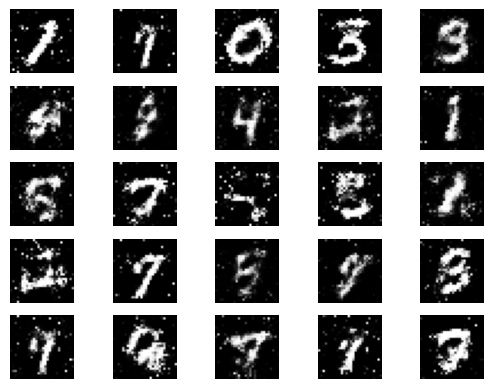

array([[[[2.68220901e-07],
         [4.32133675e-06],
         [9.11027193e-04],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [2.08616257e-07]],

        [[3.73452902e-04],
         [1.34110451e-06],
         [2.98023224e-08],
         ...,
         [8.94069672e-08],
         [1.19209290e-07],
         [8.94069672e-08]],

        [[2.83122063e-06],
         [1.89363956e-03],
         [6.89357519e-04],
         ...,
         [2.03251839e-05],
         [0.00000000e+00],
         [0.00000000e+00]],

        ...,

        [[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [2.94148922e-05]],

        [[2.08616257e-07],
         [9.98144865e-01],
         [0.00000000e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [2.30371952e-05]],

        [[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
 

In [63]:
img_list = []
G_losses = []
D_losses = []
sample_interval=25
print("Starting Training")
for epoch in range(n_epochs):
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
      disc_model.zero_grad()
      true_imgs = data[0].to(device)
      true_labels = torch.ones(true_imgs.shape[0], dtype=torch.float, device=device)
      d_output_true = disc_model(true_imgs).view(-1)
      d_loss_true = bce_criterion(d_output_true, true_labels)
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()
      z_latent_noise = torch.randn(true_imgs.shape[0], 1, 1,10, device=device)
      fake_imgs = gen_model(z_latent_noise)
      fake_labels = torch.zeros(fake_imgs.shape[0], dtype=torch.float, device=device)
      disc_output_fake = disc_model(fake_imgs.detach()).view(-1)
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      optimizer_disc.step()
      d_loss_total = d_loss_true+disc_loss_fake
    gen_model.zero_grad()
    disc_gen_output_fake = disc_model(fake_imgs).view(-1)
    g_loss = loss_fn_gen(disc_gen_output_fake)
    g_loss.backward()
    optimizer_gen.step()
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())
  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

sample_images(gen_model,z_dim, rand_seed=30)

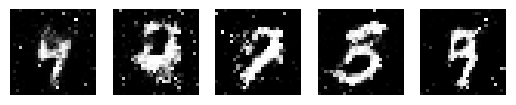

In [88]:
generated_images = sample_images(gen_model, 10, rand_seed=30)

In [33]:
generated_images.shape

(25, 28, 28, 1)

In [89]:
from sklearn.metrics import mean_squared_error
from keras.datasets import mnist
generated_images_2d = generated_images.reshape(-1, 784)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
mnist_digits = [9,0,7,5,9]
mnist_images = x_train[mnist_digits].reshape(-1, 784)

mse = mean_squared_error(mnist_images, generated_images_2d)

print(f"The Mean Squared Error between the generated images and the MNIST images is: {mse}")


The Mean Squared Error between the generated images and the MNIST images is: 7488.26318359375


In [66]:

mnist_images = mnist_images.astype('float32')
generated_images_np = generated_images.astype('float32')

psnr_value = cv2.PSNR(mnist_images, generated_images_2d)

print(f"The Peak Signal-to-Noise Ratio between the generated images and the MNIST images is: {psnr_value}")


The Peak Signal-to-Noise Ratio between the generated images and the MNIST images is: 9.93830205041836
